Problem Statement: This model will attempt to predict the outcomes of professional league of legends matches. I have a dataset consiting of professional matches from 2015 to 2018. The dataset contains matches from all over the world in individual regions, as well as, international tournaments.

I plan to use in game statistics/metrics associated with individual wins to create my model. I will then predict/test on season long or mid-season long averages of these metrics to predict their next game. For example, I will use averages of the metrics used in the model for the prior 9 games of the season to predict the outcome of the 10th game.

Data retrieved from: https://www.kaggle.com/chuckephron/leagueoflegends

Test/Train breakdown from: http://homepages.cae.wisc.edu/~ece539/project/f03/kahn.pdf

In [90]:
#Package Import
import pandas as pd
import numpy as np
import os
from pynverse import inversefunc
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

os.chdir('C:\\Users\\pobryant\documents\leagueoflegends')

In [91]:
#Listing all files in dir
os.listdir()

['bans.csv',
 'gold.csv',
 'kills.csv',
 'LeagueofLegends.csv',
 'LoL predictive model-checkpoint.ipynb',
 'LoL predictive model.ipynb',
 'matchinfo.csv',
 'monsters.csv',
 'structures.csv',
 'test.csv',
 '_columns.csv']

All of the data is stored in seperate files organized by the different variables the dataset tracks from the games. For our purposes, we will first munge the matchinfo dataset to store match information like team, season,  year, and the primary key field we will use to join all the dataset together.

The data is also stored at a match level. So each row would generally contain information for two teams. These teams can be split by side (red and blue side). Which we will do in order to calculate our metrics at a team level.

Finally, we will do similar munging in the gold, structures, and monsters datasets for the metrics we think will be associated with winning games. Because so much data munging is required to even test metrics we will have to rely heavily on our knowledge of the game to select possible features for the model.

In [92]:
#Data Import
matchinfo = pd.read_csv('matchinfo.csv')
kills = pd.read_csv('kills.csv')
monsters = pd.read_csv('monsters.csv')
structures = pd.read_csv('structures.csv')
gold = pd.read_csv('gold.csv')

In [93]:
#Creating key for joining datasets (last 16 digits of URL)
matchinfo['matchid'] = matchinfo['Address'].astype(str).str[-16:]
kills['matchid'] = kills['Address'].astype(str).str[-16:]
monsters['matchid'] = monsters['Address'].astype(str).str[-16:]
structures['matchid'] = structures['Address'].astype(str).str[-16:]
gold['matchid'] = gold['Address'].astype(str).str[-16:]

In [94]:
#Initial data munging to organize the match info dataset by team instead of game
matchinfo['ind'] = range(1, len(matchinfo) + 1)
rmatchinfo = matchinfo.filter(items =['ind','League','Year','Season','Type','rResult','redTeamTag','matchid'])
rmatchinfo['side'] = 'red'
rmatchinfo = rmatchinfo.rename(index=str, columns={"rResult": "result","redTeamTag": "teamTag"})
bmatchinfo = matchinfo.filter(items=['ind','League','Year','Season','Type','bResult','blueTeamTag','matchid'])
bmatchinfo['side'] = 'blue'
bmatchinfo = bmatchinfo.rename(index=str, columns={"bResult": "result","blueTeamTag": "teamTag"})

#Create teamid variable so we can calculate metrics by team and join by teamid
minfo = bmatchinfo.append(rmatchinfo)
minfo = minfo.sort_values(by=['ind'])
minfo['teamid'] = minfo['matchid']+minfo['side']

#Removing games prior to a major update to the game that affects the metrics we are using to evaluate teams
old_dragon_id = monsters[ monsters['Type']=="DRAGON"]['matchid'].unique()
monsters = monsters[~monsters['matchid'].isin(old_dragon_id)]
minfo = minfo[ ~minfo['matchid'].isin(old_dragon_id)]

minfo.head()

,ind,League,Year,Season,Type,result,teamTag,matchid,side,teamid
335,336,NALCS,2016,Summer,Season,0,CLG,55109b5a7a91ae87,red,55109b5a7a91ae87red
335,336,NALCS,2016,Summer,Season,1,TSM,55109b5a7a91ae87,blue,55109b5a7a91ae87blue
336,337,NALCS,2016,Summer,Season,1,TSM,e147296c928da5b4,red,e147296c928da5b4red
336,337,NALCS,2016,Summer,Season,0,CLG,e147296c928da5b4,blue,e147296c928da5b4blue
337,338,NALCS,2016,Summer,Season,0,NRG,ea0611c44259f062,red,ea0611c44259f062red


In [95]:
#Similar data munging on the gold dataset in order to store data by team not by game
#We use the melt function because each minute is stored as a seperate column which is not ideal
melt_gold = pd.melt(gold, ['Address', 'Type'], var_name='minute')
melt_gold = melt_gold[melt_gold['Type'].isin(['goldblue','goldred'])]
melt_gold = melt_gold[melt_gold['minute']. isin(['min_5','min_15','min_20'])]
melt_gold['matchid'] = melt_gold['Address'].astype(str).str[-16:]

#Filtering for each side so we can do gold calculations by team
rmelt_gold = melt_gold[melt_gold['Type'] == 'goldred']
melt_gold = melt_gold[melt_gold['Type'] == 'goldblue']
melt_gold['side'] = 'blue'
rmelt_gold['side'] = 'red'

#combining the two dataframes after team labels have been created
melt_gold = melt_gold.append(rmelt_gold)
melt_gold['teamid'] = melt_gold['matchid'] + melt_gold['side']
melt_gold.head()

,Address,Type,minute,value,matchid,side,teamid
403860,http://matchhistory.na.leagueoflegends.com/en/...,goldblue,min_5,5068,fbb300951ad8327c,blue,fbb300951ad8327cblue
403861,http://matchhistory.na.leagueoflegends.com/en/...,goldblue,min_5,5511,055b17da8456fdc8,blue,055b17da8456fdc8blue
403862,http://matchhistory.na.leagueoflegends.com/en/...,goldblue,min_5,4933,8e8a9b58df366e2d,blue,8e8a9b58df366e2dblue
403863,http://matchhistory.na.leagueoflegends.com/en/...,goldblue,min_5,5398,0ed1cd0e0e57329c,blue,0ed1cd0e0e57329cblue
403864,http://matchhistory.na.leagueoflegends.com/en/...,goldblue,min_5,5404,f932becf86175f38,blue,f932becf86175f38blue


In [96]:
#Create indidivudal columns for each other three gold metrics
#filter for the three minute values we care about
mg5 = melt_gold[melt_gold['minute'] == 'min_5']
mg15 = melt_gold[melt_gold['minute'] == 'min_15']
mg20 = melt_gold[melt_gold['minute'] == 'min_20']

#rename the column with the minute value
mg5 = mg5.rename(index=str, columns={"value": "golddif_5"})
mg15 = mg15.rename(index=str, columns={"value": "golddif_15"})
mg20 = mg20.rename(index=str, columns={"value": "golddif_20"})

#filter down the dataframe
mg5 = mg5.filter(items=['teamid','golddif_5'])
mg15 = mg15.filter(items=['teamid','golddif_15'])
mg20 = mg20.filter(items=['teamid','golddif_20'])

#merge the new metric columns onto our a match info dataframe
minfo = minfo.merge(mg5,on = 'teamid')
minfo = minfo.merge(mg15,on = 'teamid')
minfo = minfo.merge(mg20,on = 'teamid')
minfo.head()

,ind,League,Year,Season,Type,result,teamTag,matchid,side,teamid,golddif_5,golddif_15,golddif_20
0,336,NALCS,2016,Summer,Season,0,CLG,55109b5a7a91ae87,red,55109b5a7a91ae87red,5328,20511,29184
1,336,NALCS,2016,Summer,Season,1,TSM,55109b5a7a91ae87,blue,55109b5a7a91ae87blue,5683,23422,34903
2,337,NALCS,2016,Summer,Season,1,TSM,e147296c928da5b4,red,e147296c928da5b4red,5813,21801,31241
3,337,NALCS,2016,Summer,Season,0,CLG,e147296c928da5b4,blue,e147296c928da5b4blue,5755,21580,30286
4,338,NALCS,2016,Summer,Season,0,NRG,ea0611c44259f062,red,ea0611c44259f062red,5432,20129,27499


In [97]:
#Creating a counter to aggregate to count the number of dragons and barons a team took in a game
monsters['dragon_count'] = np.where(monsters['Team'].isin(['bDragons','rDragons']),1,0)
monsters['baron_count'] = np.where(monsters['Team'].isin(['bBarons','rBarons']),1,0)

#Splitting the dataframes based on side so we can do team specific metrics
rmonsters = monsters[monsters['Team'].isin(['rDragons','rBarons','rHeralds'])].copy()
bmonsters = monsters[monsters['Team'].isin(['bDragons','bBarons','bHeralds'])].copy()

#Creating team labels 
rmonsters['side'] = 'red'
bmonsters['side'] = 'blue'
rmonsters['teamid'] = rmonsters['matchid'] + rmonsters['side']
bmonsters['teamid'] = bmonsters['matchid'] + bmonsters['side']

In [98]:
#aggregating the counts for dragons and barons by side
rdragons = pd.DataFrame(rmonsters.groupby('teamid')['dragon_count'].sum())
bdragons = pd.DataFrame(bmonsters.groupby('teamid')['dragon_count'].sum())
rbarons = pd.DataFrame(rmonsters.groupby('teamid')['baron_count'].sum())
bbarons = pd.DataFrame(bmonsters.groupby('teamid')['baron_count'].sum())

#combining the two sides together
dragons = rdragons.append(bdragons)
barons = rbarons.append(bbarons)

#Joining the new dragon and baron counts back onto the matchinfo dataframe
minfo = minfo.merge(dragons,on='teamid')
minfo = minfo.merge(barons,on='teamid')
minfo.head()

,ind,League,Year,Season,Type,result,teamTag,matchid,side,teamid,golddif_5,golddif_15,golddif_20,dragon_count,baron_count
0,336,NALCS,2016,Summer,Season,1,TSM,55109b5a7a91ae87,blue,55109b5a7a91ae87blue,5683,23422,34903,3,1
1,337,NALCS,2016,Summer,Season,1,TSM,e147296c928da5b4,red,e147296c928da5b4red,5813,21801,31241,1,2
2,337,NALCS,2016,Summer,Season,0,CLG,e147296c928da5b4,blue,e147296c928da5b4blue,5755,21580,30286,3,0
3,338,NALCS,2016,Summer,Season,1,NV,ea0611c44259f062,blue,ea0611c44259f062blue,5656,22827,32229,3,1
4,339,NALCS,2016,Summer,Season,0,NV,b14fd1cbf4a478c7,red,b14fd1cbf4a478c7red,5534,21091,29226,4,1


In [99]:
#Splitting the structures dataset into red side/blue side and filtering for only towers
rtowers = structures[structures['Team'] == 'rTowers'].copy()
rtowers['side'] = 'red'
btowers = structures[structures['Team'] == 'bTowers'].copy()
btowers['side'] = 'blue'

#Creating teamid variable for joining
rtowers['teamid'] = rtowers['matchid'] + rtowers['side']
btowers['teamid'] = btowers['matchid'] + btowers['side']

#aggregating the towers dataset to find the minimum time a tower was takin (aka first tower time)
r_towers = pd.DataFrame(rtowers.groupby('teamid')['Time'].min())
b_towers = pd.DataFrame(btowers.groupby('teamid')['Time'].min())

#combining red and blue datasets into one and renaming columns
towers = r_towers.append(b_towers)
towers = towers.rename(index=str, columns={"Time": "first_tower",})

#Combining first tower time metric with matchinfo datframe
minfo = minfo.merge(towers,on='teamid')
minfo.head()

,ind,League,Year,Season,Type,result,teamTag,matchid,side,teamid,golddif_5,golddif_15,golddif_20,dragon_count,baron_count,first_tower
0,336,NALCS,2016,Summer,Season,1,TSM,55109b5a7a91ae87,blue,55109b5a7a91ae87blue,5683,23422,34903,3,1,12.277
1,337,NALCS,2016,Summer,Season,1,TSM,e147296c928da5b4,red,e147296c928da5b4red,5813,21801,31241,1,2,14.529
2,337,NALCS,2016,Summer,Season,0,CLG,e147296c928da5b4,blue,e147296c928da5b4blue,5755,21580,30286,3,0,19.738
3,338,NALCS,2016,Summer,Season,1,NV,ea0611c44259f062,blue,ea0611c44259f062blue,5656,22827,32229,3,1,12.248
4,339,NALCS,2016,Summer,Season,0,NV,b14fd1cbf4a478c7,red,b14fd1cbf4a478c7red,5534,21091,29226,4,1,5.702


In [100]:
#Formatting the year variable so we can concat it to make new key field
minfo['Year'] = minfo['Year'].apply(lambda x:str(int(x)))
#combining year, season, and teamtag into one variable so we can filter for season/team/year easily in a loop
minfo['season_team'] = (minfo['Year']+minfo['Season']+minfo['teamTag'])

#Creating a list of unique season/team/year to iterate through to create the test set
seasonlist = minfo['season_team'].unique()
season_avg = pd.DataFrame() #empty dataframe to append to in loop

for i in seasonlist:
    temp = minfo[minfo['season_team'] == i] #Filter to specific season/team/year in loop
    temp = temp[temp['Type'] == 'Season'] #get rid of playoffs/tournament games
    if temp.shape[0] > 1:
        result = temp.iloc[[-1]] #save the last row (last game of the season)
        temp.drop(temp.tail(1).index,inplace=True) #drop that row from the dataframe
        cols = ['golddif_5','golddif_15','golddif_20','dragon_count','baron_count','first_tower']
        temp[cols] = temp[cols].apply(pd.to_numeric, errors='coerce') #convert columns to numeric
        #aggregate all of our metrics for the season games except for the last game of the season
        temp = temp.groupby('season_team').agg({'golddif_5':'mean','golddif_15':'mean','golddif_20':'mean','dragon_count':'mean','baron_count':'mean','first_tower':'mean'})
        #filter out match result and info to append the newly calculated season metrics to
        result = result.filter(items =['ind','League','Year','Season','Type','result','teamTag','matchid','side','teamid','season_team'])
        #concat match info from last game with the aggregated metrics for the entire season 
        result = pd.concat([result.reset_index(drop=True), temp.reset_index(drop=True)], axis=1)
        season_avg = season_avg.append(result) #save result to empty dataframe

#This loop repeats the same processs but calculates metrics for the first 5 games and appends them to the minfo for the 6th game
fh_avg = pd.DataFrame()
for i in seasonlist:
    temp = minfo[minfo['season_team'] == i]
    temp = temp[temp['Type'] == 'Season']
    temp = temp.head(6)
    if temp.shape[0] == 6:
        result = temp.iloc[[-1]]
        temp.drop(temp.tail(1).index,inplace=True)
        cols = ['golddif_5','golddif_15','golddif_20','dragon_count','baron_count','first_tower']
        temp[cols] = temp[cols].apply(pd.to_numeric, errors='coerce')
        temp = temp.groupby('season_team').agg({'golddif_5':'mean','golddif_15':'mean','golddif_20':'mean','dragon_count':'mean','baron_count':'mean','first_tower':'mean'})
        result = result.filter(items =['ind','League','Year','Season','Type','result','teamTag','matchid','side','teamid','season_team'])
        result = pd.concat([result.reset_index(drop=True), temp.reset_index(drop=True)], axis=1)
        fh_avg = fh_avg.append(result)

test_set = season_avg.append(fh_avg)

The above loops are how we generate the test set. Effectively what we are doing is calculating metrics over several games prior to one specific game that we use as our label. While the model is trained on indiviual games' metrics and label, the model will be tested (and used) with season and mid-season metric averages to predict the next upcoming game.

In [101]:
#Re-combines the team specific data into match specific data so we have metrics for the losing and winning team
bminfo = minfo[minfo['side'] == 'blue']
rminfo = minfo[minfo['side'] == 'red']
rminfo = rminfo.filter(items =['matchid','golddif_5','golddif_15','golddif_20','dragon_count','baron_count','first_tower'])
rminfo = rminfo.rename(index=str, columns={"golddif_5": "rgolddif_5","golddif_15": "rgolddif_15","golddif_20": "rgolddif_20","dragon_count": "rdragon_count","baron_count": "rbaron_count","first_tower": "rfirst_tower"})
minfo2 = bminfo.merge(rminfo,on='matchid')

#Imputes missing values for first tower with the max time a first tower was taken
#These NA's exists in games where a team did not take a tower so it makes sense to just give them the max tower time in the dataset
minfo2 ['rfirst_tower'] = minfo2['rfirst_tower'].fillna(max(minfo2['rfirst_tower']))
minfo2 ['first_tower'] = minfo2['first_tower'].fillna(max(minfo2['rfirst_tower']))

#Does the same manipulation as above for the test set
btest_set = test_set[test_set['side'] == 'blue']
rtest_set = test_set[test_set['side'] == 'red']
rtest_set = rtest_set.filter(items =['matchid','golddif_5','golddif_15','golddif_20','dragon_count','baron_count','first_tower'])
rtest_set = rtest_set.rename(index=str, columns={"golddif_5": "rgolddif_5","golddif_15": "rgolddif_15","golddif_20": "rgolddif_20","dragon_count": "rdragon_count","baron_count": "rbaron_count","first_tower": "rfirst_tower"})
test_set2 = btest_set.merge(rtest_set,on='matchid')

#Final dataframe before modelling
minfo2.head()

,ind,League,Year,Season,Type,result,teamTag,matchid,side,teamid,...,dragon_count,baron_count,first_tower,season_team,rgolddif_5,rgolddif_15,rgolddif_20,rdragon_count,rbaron_count,rfirst_tower
0,337,NALCS,2016,Summer,Season,0,CLG,e147296c928da5b4,blue,e147296c928da5b4blue,...,3,0,19.738,2016SummerCLG,5813,21801,31241,1,2,14.529
1,339,NALCS,2016,Summer,Season,1,NRG,b14fd1cbf4a478c7,blue,b14fd1cbf4a478c7blue,...,2,3,3.390,2016SummerNRG,5534,21091,29226,4,1,5.702
2,340,NALCS,2016,Summer,Season,1,NV,aa0eef8f5441887e,blue,aa0eef8f5441887eblue,...,3,1,14.045,2016SummerNV,5524,20598,28466,1,0,15.112
3,341,NALCS,2016,Summer,Season,0,C9,cadc355b3ee8548f,blue,cadc355b3ee8548fblue,...,4,0,11.550,2016SummerC9,5752,21555,33382,0,1,11.302
4,342,NALCS,2016,Summer,Season,0,IMT,5905d606461c5597,blue,5905d606461c5597blue,...,2,0,3.698,2016SummerIMT,6041,21427,31382,2,1,3.824


In [102]:
#Checking class balance in train set
minfo2['result'].value_counts()

1    1906
0    1513
Name: result, dtype: int64

In [103]:
#Checking class balance in test set
test_set2['result'].value_counts()

1    63
0    53
Name: result, dtype: int64

In [104]:
#Simple two-dimensional svm
X = minfo2[['golddif_20', 'rgolddif_20']].values #Comparing the winning and losing 20_min gold values
y = minfo2['result'] #y value (win or loss)
model = SVC(kernel='linear', C=.005) #parameters for SVM
model.fit(X, y) #fitting the model

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Here we run some simple two-dimensional models so we can visualize the effectiveness of these dimensions in their ability to discriminate between a win or a loss.

We selected several gold values at different time intervals that could indicate how a team performs throughout the game. Below, we can see how well an svm can discriminate between the gold minute values at different intervals from the winning teams and losing teams.

We can see clearly that the golddif_20 and golddif_15 models look much better than the golddif_5.

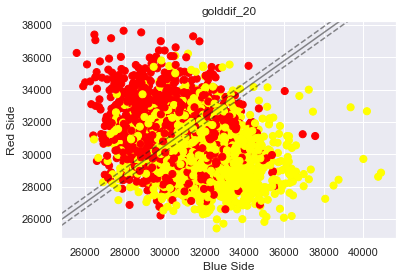

In [105]:
#Plot comparison of the 20 min gold values for the winning and losing team as well as the line generated from the SVM
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)
plt.xlabel('Blue Side')
plt.ylabel('Red Side')
plt.title('golddif_20');

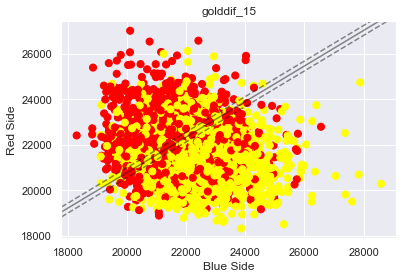

In [108]:
#Doing the same model above but with the 15_min gold values
X = minfo2[['golddif_15', 'rgolddif_15']].values
y = minfo2['result']
model = SVC(kernel='linear', C=.01)
model.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)
plt.xlabel('Blue Side')
plt.ylabel('Red Side')
plt.title('golddif_15');

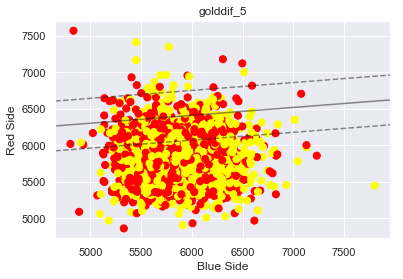

In [109]:
#Doing the same model above but with the 5_min gold values
X = minfo2[['golddif_5', 'rgolddif_5']].values
y = minfo2['result']
model = SVC(kernel='linear', C=.01)
model.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)
plt.xlabel('Blue Side')
plt.ylabel('Red Side')
plt.title('golddif_5');

In [77]:
#Final Model consisting of all variables
X = minfo2[['golddif_15','golddif_20','dragon_count','baron_count','first_tower','rgolddif_15','rgolddif_20','rbaron_count','rdragon_count','rfirst_tower']].values
y = minfo2['result']
model = SVC(kernel='linear') #model parameters
model.fit(X,y) #fitting the modelr
Xtest= test_set2[['golddif_15','golddif_20','dragon_count','baron_count','first_tower','rgolddif_15','rgolddif_20','rbaron_count','rdragon_count','rfirst_tower']].values
ytest = test_set2['result']
yfit = model.predict(Xtest) # predicting on the test set

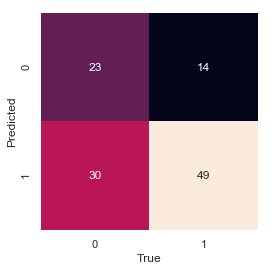

In [78]:
#Confusion matrix displaying results from the predictions on the test set
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True')
plt.ylabel('Predicted');

In summary, we munged several different datasets involving professional league of legends match statistics. This process involved seperating the datasets into team based stats instead of match based stats by splitting the red and blue side  columns into their own rows. We then calculated these metrics and joined them onto our master dataset using the teamid variable.

Then we created our test sets by calculating season and mid-season average metrics labelled with the 6th and final game of the teams season in that particular year. We also evaluated our class balance in both the train and test sets.

Finally, we created some smiple two dimensional models to look at the effectiveness of some our features in a support vector machine. Here we were able to see that the golddif_5 variable was not particularly effective at discriminating between winning teams and losing teams. For our final model we created a multi-dimensional svm that included the golddif_15, golddif_20, number of barons, number of dragons, and first tower time for both the winning and losing team. The confusion matrix above displays how effective our model was at prediciting the outcomes of the test set. We ended up having a 62% accuracy on the test set which is pretty decent. League of legends games are very volatile and can be difficult to predict. In general I believe the model is most likely just picking the favourite to win, but it is doing better than random chance so I consider that a success.